In [1]:
%pylab inline
import pandas as pd;
import numpy as np;
from matplotlib import style
import os;
import glob
import pickle
import json
import matplotlib.pyplot as plt

import scipy.io as sio
import scipy.fftpack
import scipy.signal
import scipy.io.wavfile
from scipy import stats
from scipy import signal
import mat73

from open_ephys.analysis import Session

plt.rcParams['font.size'] = 20

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Loading Data
#path = 'H:\\neuropixels\\'
file = 'D:\\_work_cestarellas\\Analysis\\PLRNN\\session_selection_v0\\OFC\\CE17\\L6\\LFP_filtered_200Hz_1000SR.mat'
Amp = mat73.loadmat(file)

# select the number of channels 
n_ch = Amp["LFP_v"].shape[1]
step = 50
# number of selected channels to plot
total_select = 5

fig, ax = plt.subplots(nrows = total_select, ncols =1, figsize = (25,10), sharex = True)
sm_rate = 20000
xlim = sm_rate*0#52
ylim = sm_rate*5#57
time_vec = np.linspace(xlim/sm_rate,ylim/sm_rate,ylim)

for i, ch in enumerate(range(total_select)): # from channel 0 to channel 15
    ax[i].plot(time_vec,Amp["LFP_v"][xlim:ylim,i], lw = 1) # 20_000 samples means one second of recording
    ax[i].set_ylim(-5000,5000) # y-axis limts
    ax[i].set_ylabel(f'Channel {ch*step:2d}', rotation=0) # write a label
    ax[i].set_yticks([])
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
ax[total_select-1].set_xlabel('Time (s)')
plt.tight_layout()

Text(0, 0.5, "Animal's choice")

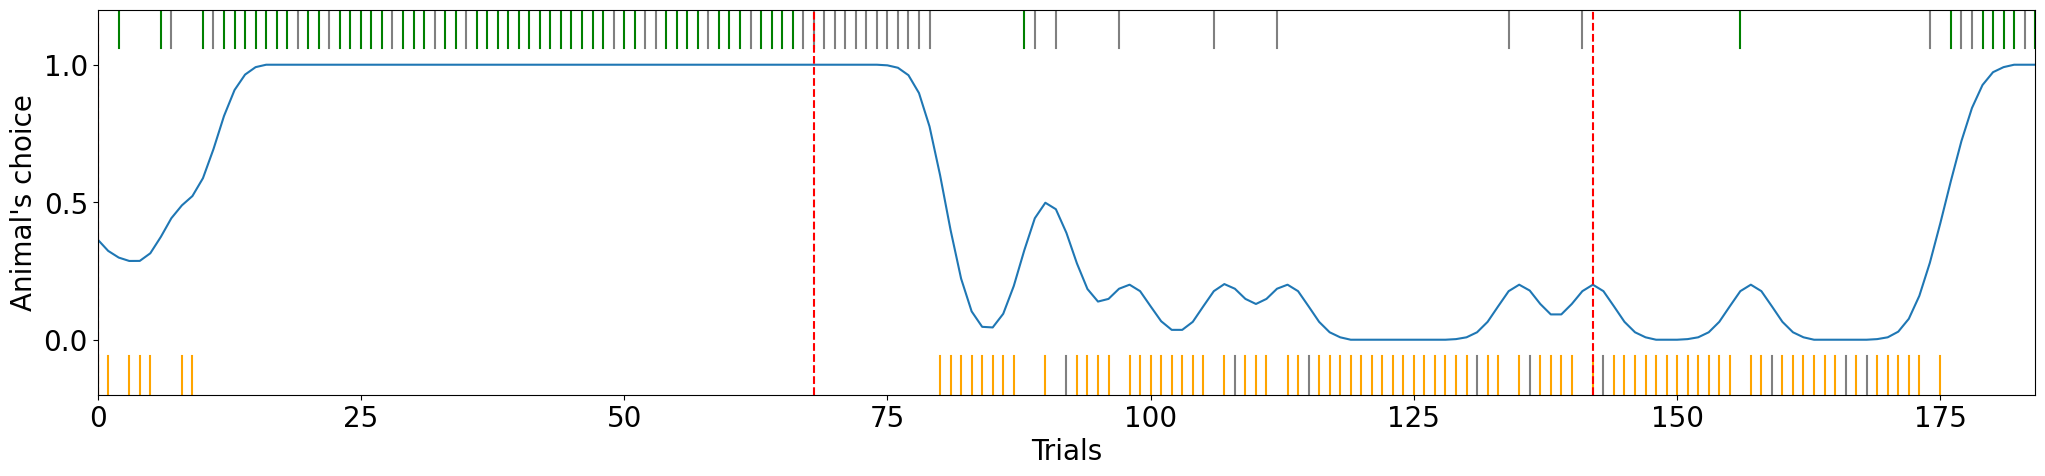

In [8]:
# Loading Behaviour
# behavioral information

path='D:/_work_cestarellas/Analysis/PLRNN/Session_Selected/OFC/CE17_L6'   # Pathway of the data (behaviour & Spike activity)

# Selection of the file
os.chdir(path)
list_files = os.listdir(path)
for i in list_files:
    if i.find('Behaviour')>0:
        Behaviour_name = i

# Load data
# Open the Behaviour file
Bdata = scipy.io.loadmat(Behaviour_name)
BehData = Bdata[list(Bdata.keys())[-1]]

# Classification of trials following the behabiour
GambleRewardTrials = np.where((BehData[:,12]==1) & (BehData[:,13]==1))[0]
GambleNoRewardTrials =  np.where((BehData[:,12]==1) & (BehData[:,13]==0))[0]
SafeRewardTrials = np.where((BehData[:,12]==0) & (BehData[:,13]==1))[0]
SafeNoRewardTrials = np.where((BehData[:,12]==0) & (BehData[:,13]==0))[0]
NoRespondingTrials = np.where(BehData[:,10]==1)[0]

# Blocks
Block_Prob = np.unique(BehData[:,5])
BlockTrials = [np.where(Block_Prob[i]==BehData[:,5])[0][0] for i in range(len(Block_Prob))]
# Smoothing the data for plotting
ScaleDecision=BehData[:,12]+(BehData[:,12]-1)
SigmaDecision=1
Binx =0.5
KernelWindow = np.arange(-3*SigmaDecision, 3*SigmaDecision, Binx)
KernelDecision = np.exp(-(KernelWindow/SigmaDecision)**2/2)
DecisionConvolution=np.convolve(ScaleDecision,KernelDecision,mode='same')
DecisionNormalized=(DecisionConvolution/np.nanmax(np.abs(DecisionConvolution))+1)/2
if NoRespondingTrials[0]<20:
    first_trial = NoRespondingTrials[0]+1
    last_trial = NoRespondingTrials[1]-1
else:
    first_trial = 0
    last_trial = NoRespondingTrials[0]-1
    
first_trial = 0
last_trial = NoRespondingTrials[0]-1

# FIGURE: Plot behaviour performance
plt.figure(figsize=(25,5))
plt.plot(DecisionNormalized)
for i in GambleRewardTrials:
    plt.axvline(i,ymin=0.9,ymax=1.0,color='g') 
for i in GambleNoRewardTrials:
    plt.axvline(i,ymin=0.9,ymax=1.0,color='gray')
for i in SafeRewardTrials:
    plt.axvline(i,ymin=0.0,ymax=0.1,color='orange')
for i in SafeNoRewardTrials:
    plt.axvline(i,ymin=0.0,ymax=0.1,color='gray')
for i in NoRespondingTrials:
    plt.axvline(i,ymin=0.45,ymax=0.55,color='blue')
for i in BlockTrials:
    plt.axvline(i,linestyle='dashed',color='r',)     
plt.ylim([-0.2,1.2])
plt.yticks(ticks=[1.0,0.5,0.0])
plt.xlim([first_trial,last_trial])
plt.xlabel('Trials')
plt.ylabel("Animal's choice")


In [15]:
# Info Columns BehData:
# 0- Trial Start
# 1- Trial End
# 2- Duration (Seconds)
# 3- Block
# 4- Gamble Arm (Right = 1, Left = 0)
# 5- Probability big Reward
# 6- Probability Small Reward
# 7- Ammount Big Reward
# 8- Ammount Small Reward
# 9- Number of previously wheel not stopping
# 10- Not responding Trial
# 11- Chosen Side (Right = 1, Left = 0)
# 12- Chosen Arm (Gamble = 1, Safe = 0)
# 13- Reward Given
# 14- Start of the trial (Sampling points)
# 15- Cue Presentation (Sampling Points)
# 16- Start of the response window (Sampling Points)
# 17- Reward Period (Sampling Points)
# 18- End of the trial
SR = 20000
SR_fil = 1000
Sampling_events = (BehData[:,14::]/SR*SR_fil).astype(int)
Sampling_events = Sampling_events-Sampling_events[0,0]

In [16]:
Sampling_events

array([[      0,    1000, -712779,    1779,    8790],
       [   8790,    9790, -712779,   10145,   13668],
       [  13668,   14668, -712779,   15277,   19890],
       ...,
       [1158785, 1159785, -712779, 1160113, 1163125],
       [1163125, 1164125, -712779, 1164464, 1167949],
       [1167949, 1168949, -712779, 1169318, 1171318]])

[2,
 6,
 10,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 20,
 21,
 23,
 24,
 25,
 26,
 27,
 29,
 30,
 31,
 33,
 34,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 50,
 51,
 54,
 55,
 56,
 57,
 59,
 60,
 61,
 63,
 64,
 65,
 66,
 88,
 156,
 176,
 179,
 180,
 181,
 182,
 184,
 186,
 188,
 191,
 192,
 193,
 194,
 195,
 196,
 198,
 199,
 205,
 206,
 208,
 210,
 212,
 214]

# Analyzing LFP full session

In [74]:
# Intial and Final temporal points
Ti = Sampling_events[0,0]
Tf = Sampling_events[-1,-1]
srate = 1000
# time vector
LFP =  Amp["LFP_v"][Ti:Tf,20]
LFP = LFP - LFP.mean()
sampling_rate = 1000
N = len(LFP)

Text(0, 0.5, 'Power')

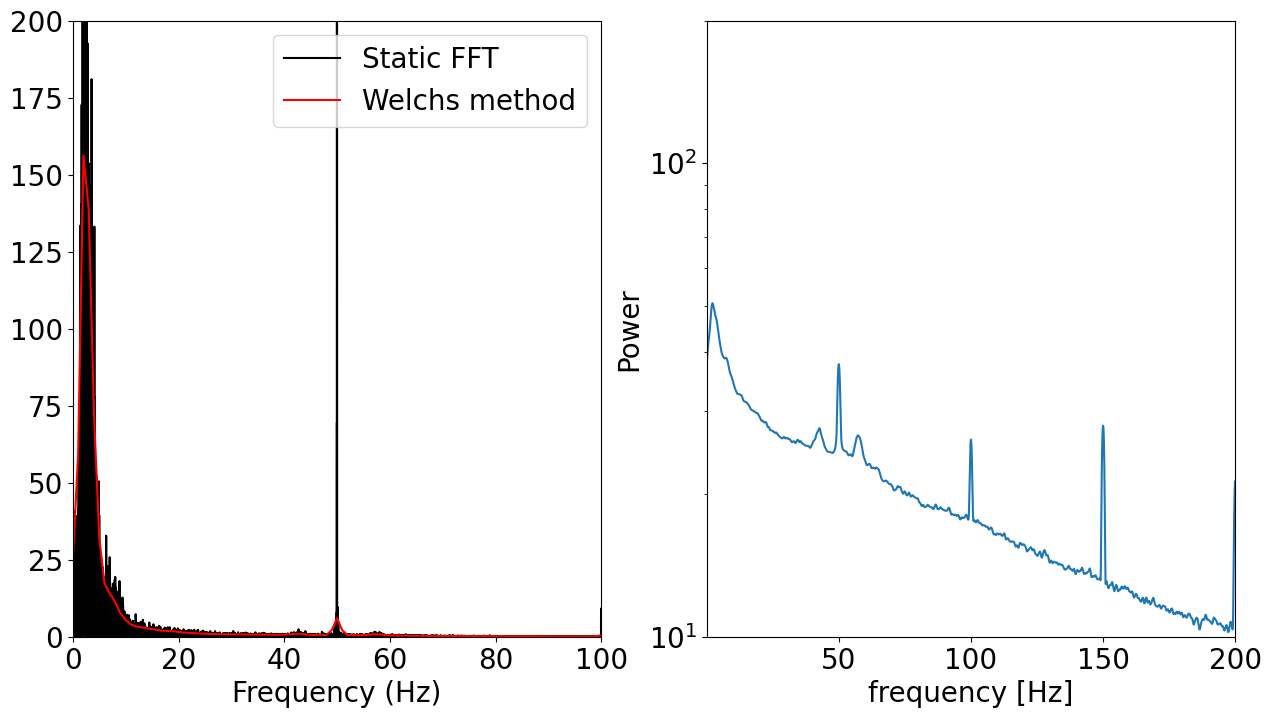

In [41]:
# 1. Power spectrum
## one big FFT (not Welch's method)
# "static" FFT over entire period, for comparison with Welch
lfppow = np.abs(scipy.fftpack.fft(LFP)/N )**2 ## power spectrum
hz = np.linspace(0,srate/2,int(np.floor(N/2)+1))

## 1 "manual" Welch's method
winlength = int( 1*srate )# window length in seconds*srate
nOverlap = np.round(srate/2)# number of points of overlap

# window onset times
winonsets = np.arange(0,int(N-winlength),int(winlength-nOverlap))
# note: different-length signal needs a different-length Hz vector
hzW = np.linspace(0,srate/2,int(floor(winlength/2)+1))
# Hann window
hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,int(winlength)))/2
# initialize the power matrix (windows x frequencies)
lfppowW = np.zeros(len(hzW))

# loop over frequencies
for wi in range(0,len(winonsets)):
    datachunk = LFP[ winonsets[wi]:winonsets[wi]+winlength ]# get a chunk of data from this time window
    datachunk = datachunk * hannw# apply Hann taper to data
    tmppow = np.abs(scipy.fftpack.fft(datachunk)/winlength)**2 # compute its power
    lfppowW = lfppowW  + tmppow[0:len(hzW)]# enter into matrix

lfppowW = lfppowW / len(winonsets)# divide by N

## 2 Python's welch
# create Hann window
winsize = int( 2*srate ) # 2-second window size
hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,winsize))/2  #hanntaper. It attenuates the edges effect

# number of FFT points (frequency resolution)
nfft = srate*100 # it is bigger than winsize. Frequency resolution is higher the plot gets smoother
# here by diving by 4 we have 25% overlap
f, welchpow = scipy.signal.welch(LFP,fs=srate,window=hannw,nperseg=winsize,noverlap=winsize/4,nfft=nfft)

# 3 Plotting
fig,ax = plt.subplots(1, 2, figsize = (15,8), sharex = False)
ax[0].plot(hz,lfppow[0:len(hz)],'k',label='Static FFT')
ax[0].plot(hzW,lfppowW/100,'r',label='Welch''s method')
#ax[0].set_yscale('log')
ax[0].set_xlim([0,100])
ax[0].set_ylim([0,200])
ax[0].set_xlabel('Frequency (Hz)')
ax[0].legend()

ax[1].semilogy(f,10*np.log10(welchpow))
ax[1].set_xlim([0.1,200])
ax[1].set_xlabel('frequency [Hz]')
ax[1].set_ylabel('Power')


Text(0, 0.5, 'Power')

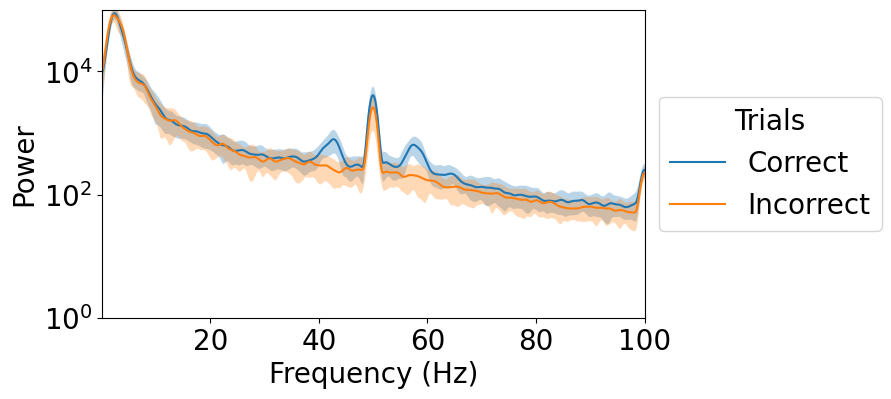

In [31]:
# Reward Power Spectrum
freq_rew = []
lfp_rew = []
for i in list(GambleRewardTrials):
    # Intial and Final temporal points
    Ti = Sampling_events[i,0]
    Tf = Sampling_events[i,-1]
    srate = 1000
    # time vector
    LFP_rew =  LFP[Ti:Tf]
    LFP_rew = LFP_rew - LFP_rew.mean()
    sampling_rate = 1000
    N = len(LFP_rew)

    # create Hann window
    winsize = int(srate) # 2-second window size
    hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,winsize))/2  #hanntaper. It attenuates the edges effect

    # number of FFT points (frequency resolution)
    nfft = srate*100 # it is bigger than winsize. Frequency resolution is higher the plot gets smoother
    # here by diving by 4 we have 25% overlap
    f, welchpow = scipy.signal.welch(LFP_rew,fs=srate,window=hannw,nperseg=winsize,noverlap=winsize/4,nfft=nfft)
    freq_rew.append(f)
    lfp_rew.append(welchpow)

F_rew = np.array(freq_rew).mean(0)
PS_rew = np.array(lfp_rew).mean(0)
PS_rew_std = np.array(lfp_rew).std(0)

# Unreward Power Spectrum
freq_unrew = []
lfp_unrew = []
for i in list(GambleNoRewardTrials):
    # Intial and Final temporal points
    Ti = Sampling_events[i,0]
    Tf = Sampling_events[i,-1]
    srate = 1000
    # time vector
    LFP_unrew =  LFP[Ti:Tf]
    LFP_unrew = LFP_unrew - LFP_unrew.mean()
    sampling_rate = 1000
    N = len(LFP_unrew)

    # create Hann window
    winsize = int(srate) # 2-second window size
    hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,winsize))/2  #hanntaper. It attenuates the edges effect

    # number of FFT points (frequency resolution)
    nfft = srate*100 # it is bigger than winsize. Frequency resolution is higher the plot gets smoother
    # here by diving by 4 we have 25% overlap
    f, welchpow = scipy.signal.welch(LFP_unrew,fs=srate,window=hannw,nperseg=winsize,noverlap=winsize/4,nfft=nfft)
    freq_unrew.append(f)
    lfp_unrew.append(welchpow)

F_unrew = np.array(freq_unrew).mean(0)
PS_unrew = np.array(lfp_unrew).mean(0)
PS_unrew_std = np.array(lfp_unrew).std(0)

plt.figure(figsize=(7,4))
plt.semilogy(F_rew,PS_rew, label = 'Correct')
plt.fill_between(F_rew, PS_rew - PS_rew_std, PS_rew + PS_rew_std, alpha=0.3)
plt.semilogy(F_unrew,PS_unrew, label = 'Incorrect')
plt.fill_between(F_unrew, PS_unrew - PS_unrew_std, PS_unrew + PS_unrew_std, alpha=0.3)
plt.xlim([0.1,100])
plt.ylim([1,100000])
plt.legend(title="Trials",loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")

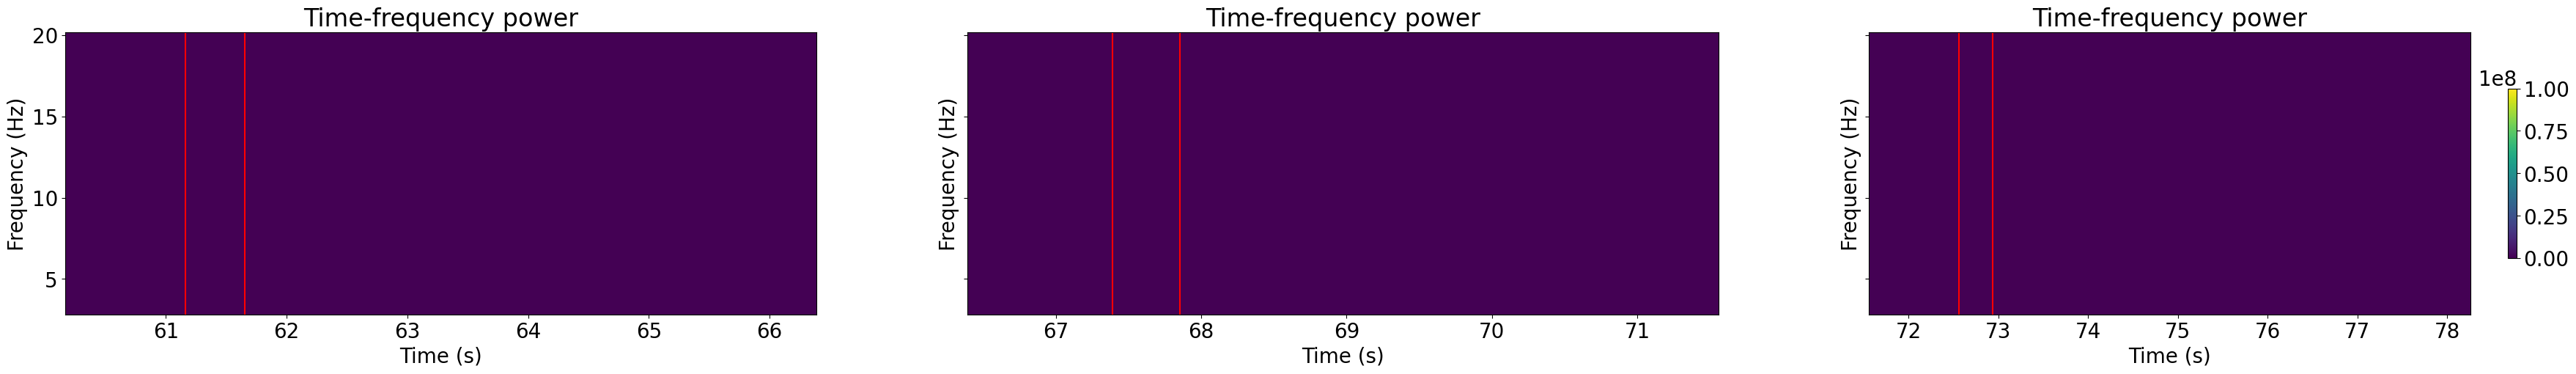

In [76]:
## Now let's apply morlet
# wavelet parameters
nfrex = 50 # 50 frequencies
frex  = np.linspace(3,20,nfrex) # 50 frequencies that are generated linearly between 8 and 70 Hz
fwhm  = 1/frex # full-width at half-maximum in seconds

# time vector for wavelets
wavetime = np.arange(-2,2,1/srate)
N = LFP.shape[0]
timevec = np.arange(0,N)/srate

# initialize matrices for wavelets
wavelets = np.zeros( (nfrex,len(wavetime)) ,dtype=complex)

# create complex Morlet wavelet family
for wi in range(0,nfrex):    
    gaussian = np.exp( -(4*np.log(2)*wavetime**2) / fwhm[wi]**2 )   # Gaussian  
    wavelets[wi,:] = np.exp(1j*2*np.pi*frex[wi]*wavetime) * gaussian # complex Morlet wavelet

# 1 Run convolution using spectral multiplication

#use the fileter data as data
data = LFP # low passes and notched data 

# convolution parameters
nconv = len(timevec) + len(wavetime) - 1 # M+N-1
halfk = int( np.floor(len(wavetime)/2) )

# Fourier spectrum of the signal
dataX = scipy.fftpack.fft(data,nconv) # here we can the fft of the data only once

# initialize time-frequency matrix. The whole trial
tf = np.zeros( (nfrex,len(timevec)) )

# convolution per frequency. We alternatively use the python conv function
for fi in range(0,nfrex):      
    waveX = scipy.fftpack.fft(wavelets[fi,:],nconv)# FFT of the wavelet    
    waveX = waveX / np.abs(np.max(waveX)) # amplitude-normalize the wavelet in the frequency domain    
    convres = scipy.fftpack.ifft( waveX*dataX ) # convolution # inverse of the ifft    
    convres = convres[halfk-1:-halfk]  # trim the "wings"  # result is also complex    
    tf[fi,:] = np.abs(convres)**2 # # extract power from complex signal, we get the magnitude(np.abs)

# Intial and Final temporal points
trials = 3
fig,ax = plt.subplots(1, 3, figsize = (45,5), sharey = True)
i=9
for a in ax:
    i+=1
    Ti = Sampling_events[i,0]
    Tf = Sampling_events[i,4]
    Ts = Sampling_events[i,1]
    Tr = Sampling_events[i,3]
    pcm = a.pcolormesh(timevec[Ti:Tf],frex,tf[:,Ti:Tf],vmin=0,vmax=1e8)
    a.axvline(timevec[Ts],c='r')
    a.axvline(timevec[Tr],c='r')
    a.set_xlabel('Time (s)'), a.set_ylabel('Frequency (Hz)')
    a.set_title('Time-frequency power')
fig.colorbar(pcm, shrink=0.6)

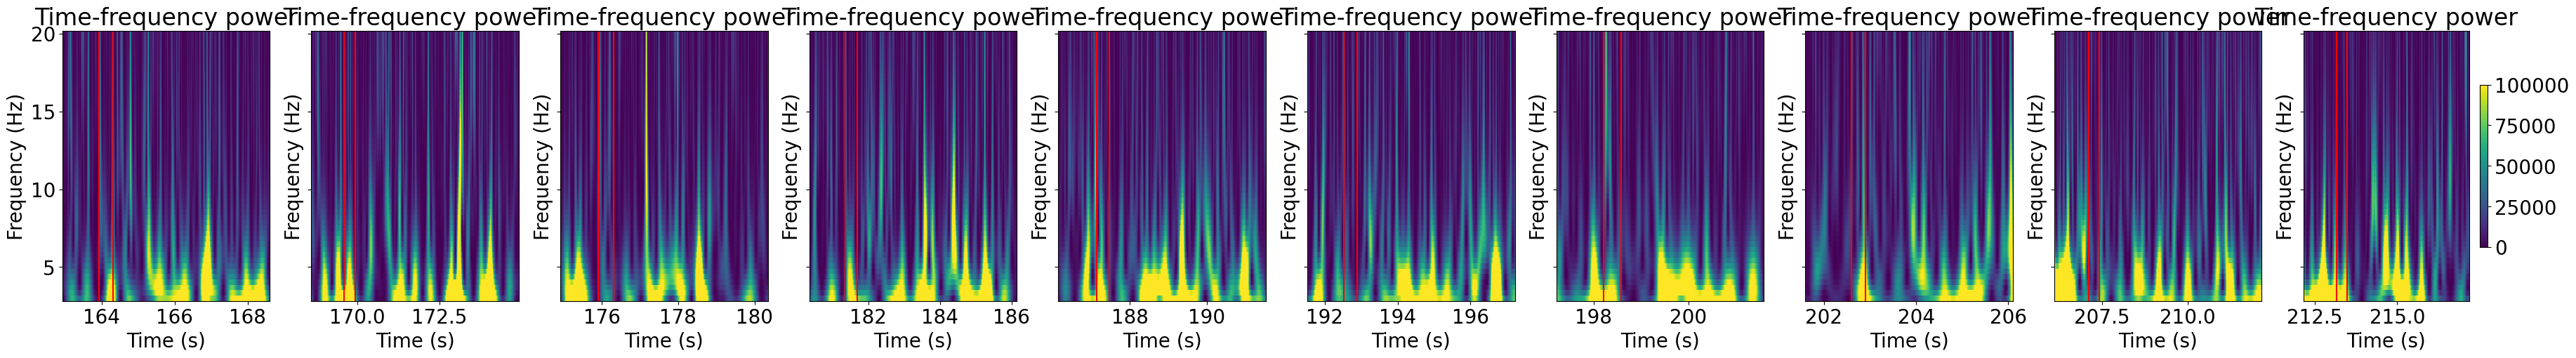

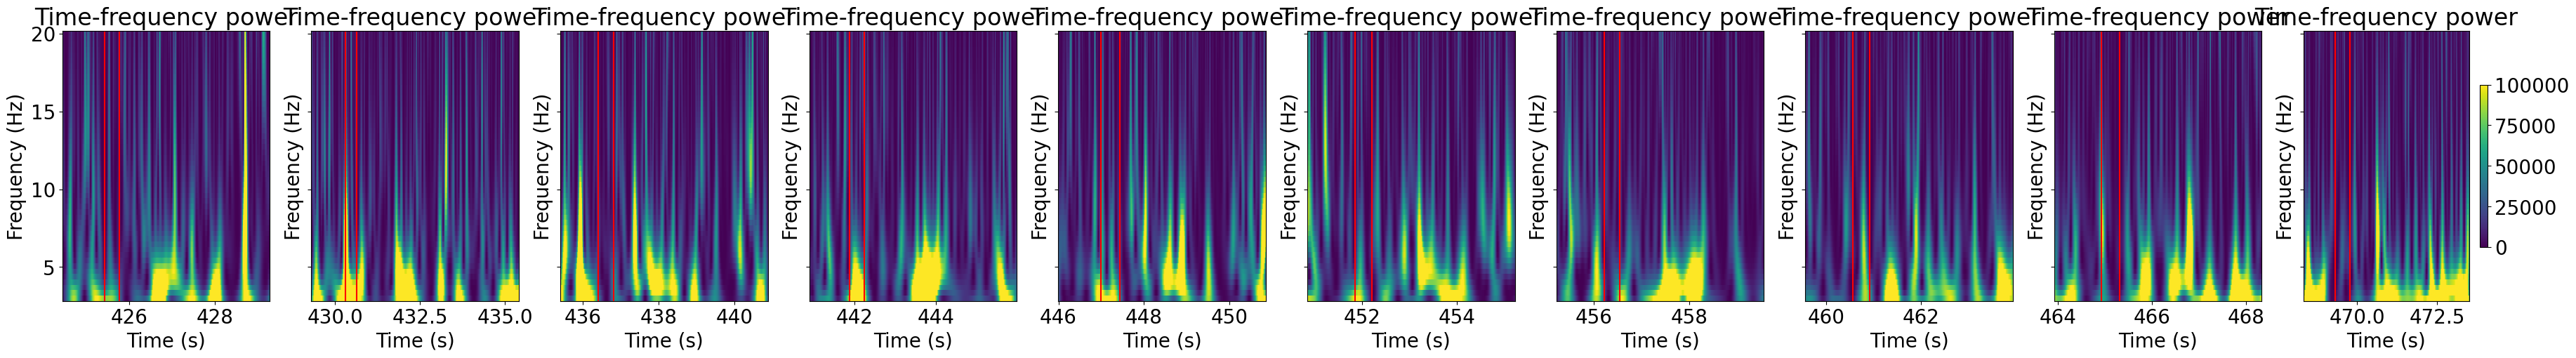

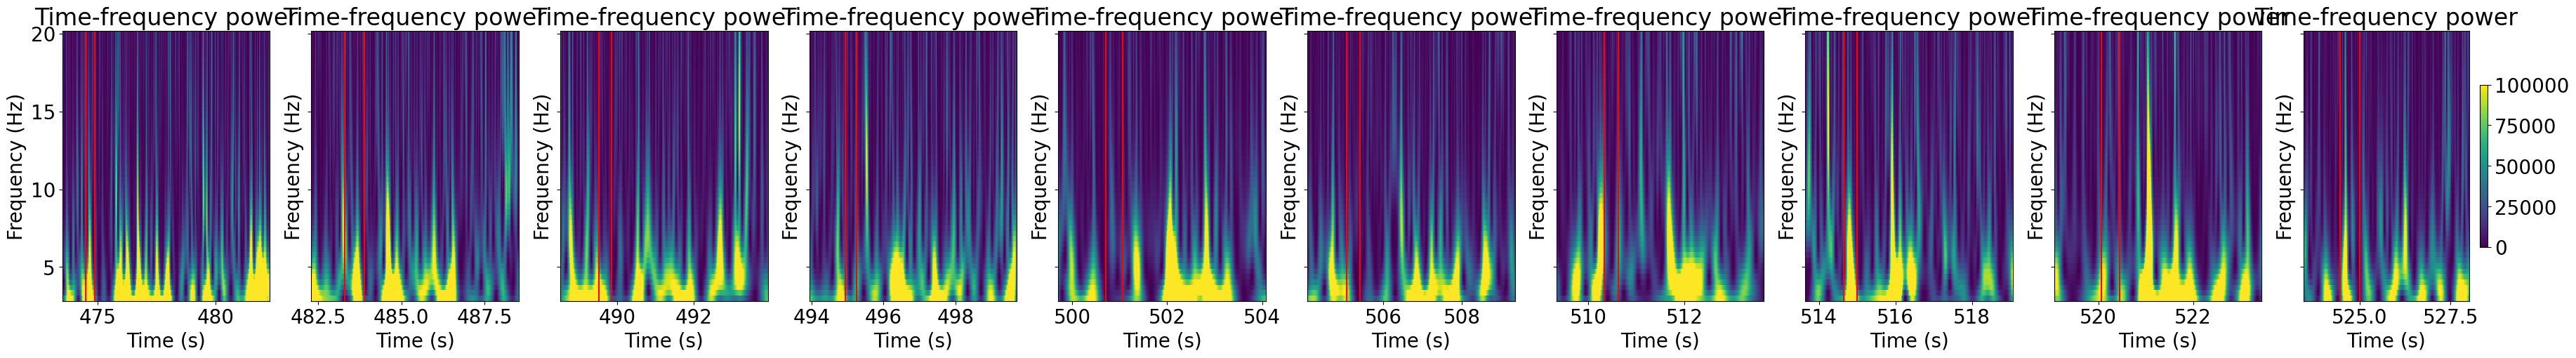

In [47]:
# Intial and Final temporal points
trials = 3
fig,ax = plt.subplots(1, 10, figsize = (45,5), sharey = True)
i=25
for a in ax:
    i+=1
    Ti = Sampling_events[i,0]
    Tf = Sampling_events[i,4]
    Ts = Sampling_events[i,1]
    Tr = Sampling_events[i,3]
    pcm = a.pcolormesh(timevec[Ti:Tf],frex,tf[:,Ti:Tf],vmin=0,vmax=1e5)
    a.axvline(timevec[Ts],c='r')
    a.axvline(timevec[Tr],c='r')
    a.set_xlabel('Time (s)'), a.set_ylabel('Frequency (Hz)')
    a.set_title('Time-frequency power')
fig.colorbar(pcm, shrink=0.6)

# Intial and Final temporal points
trials = 3
fig,ax = plt.subplots(1, 10, figsize = (45,5), sharey = True)
i=70
for a in ax:
    i+=1
    Ti = Sampling_events[i,0]
    Tf = Sampling_events[i,4]
    Ts = Sampling_events[i,1]
    Tr = Sampling_events[i,3]
    pcm = a.pcolormesh(timevec[Ti:Tf],frex,tf[:,Ti:Tf],vmin=0,vmax=1e5)
    a.axvline(timevec[Ts],c='r')
    a.axvline(timevec[Tr],c='r')
    a.set_xlabel('Time (s)'), a.set_ylabel('Frequency (Hz)')
    a.set_title('Time-frequency power')
fig.colorbar(pcm, shrink=0.6)

# Intial and Final temporal points
trials = 3
fig,ax = plt.subplots(1, 10, figsize = (45,5), sharey = True)
i=80
for a in ax:
    i+=1
    Ti = Sampling_events[i,0]
    Tf = Sampling_events[i,4]
    Ts = Sampling_events[i,1]
    Tr = Sampling_events[i,3]
    pcm = a.pcolormesh(timevec[Ti:Tf],frex,tf[:,Ti:Tf],vmin=0,vmax=1e5)
    a.axvline(timevec[Ts],c='r')
    a.axvline(timevec[Tr],c='r')
    a.set_xlabel('Time (s)'), a.set_ylabel('Frequency (Hz)')
    a.set_title('Time-frequency power')
fig.colorbar(pcm, shrink=0.6)

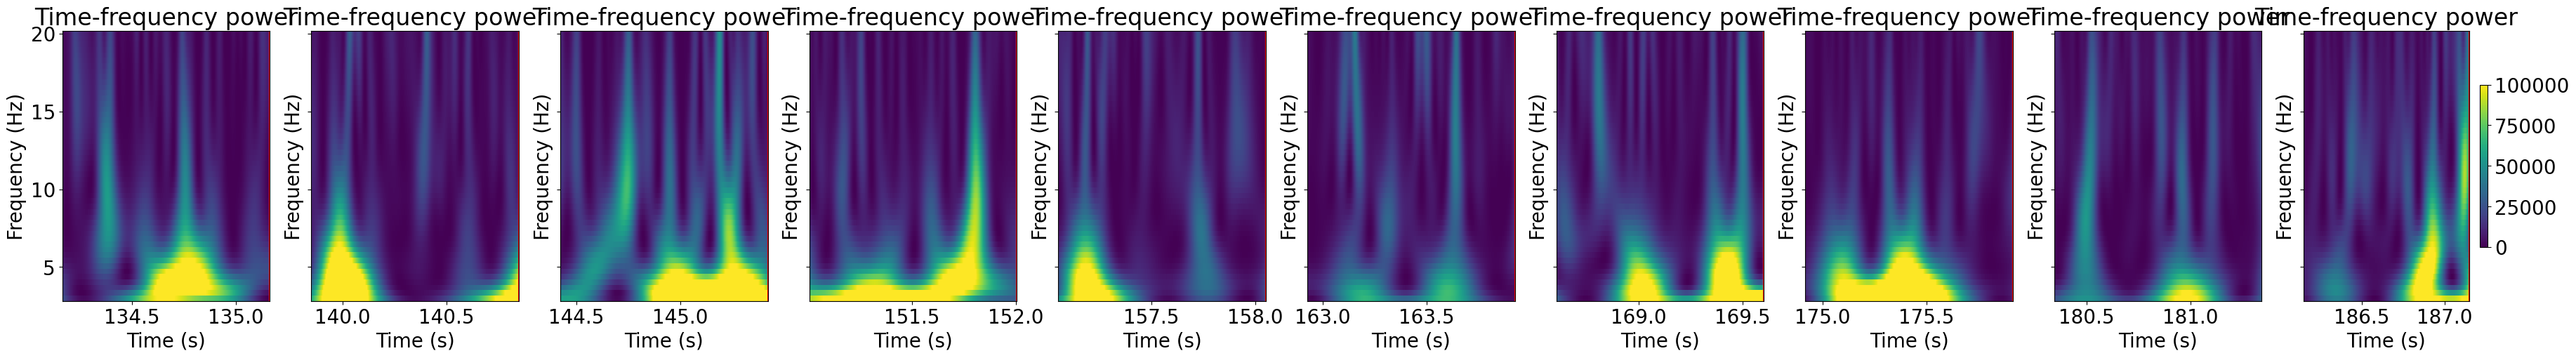

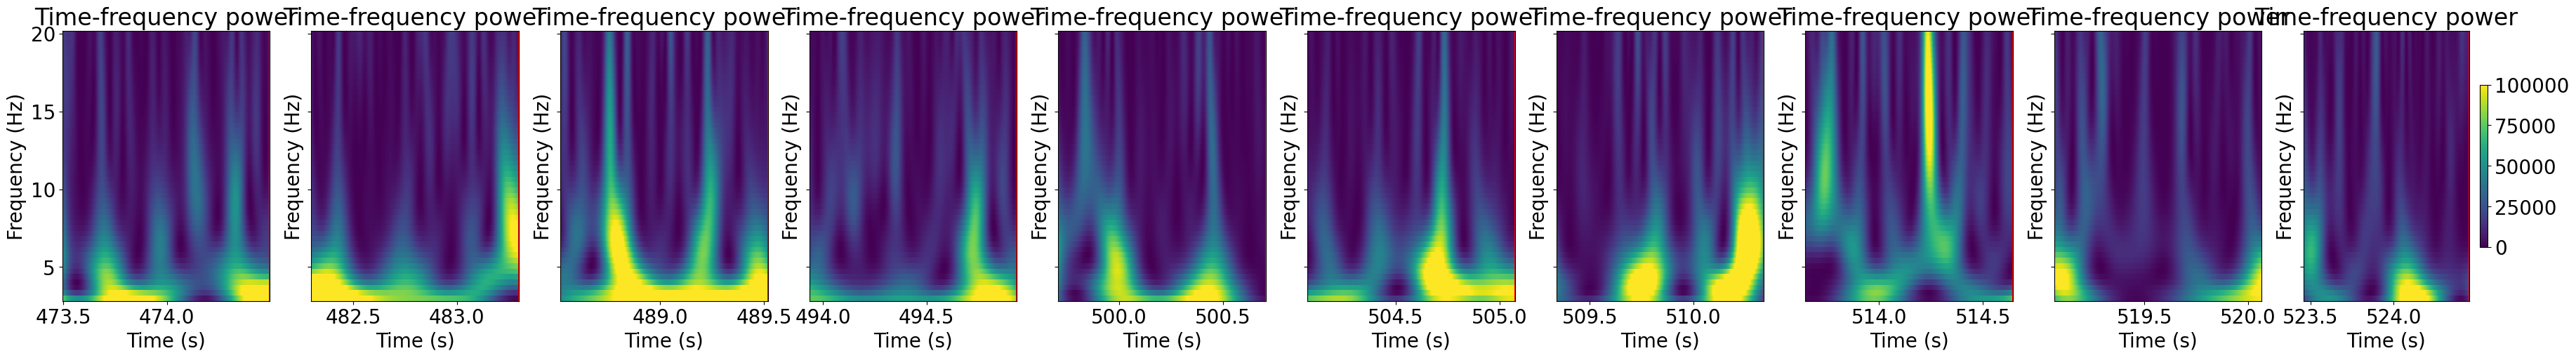

In [50]:
# Intial and Final temporal points
# Intial and Final temporal points
trials = 3
fig,ax = plt.subplots(1, 10, figsize = (45,5), sharey = True)
i=20
for a in ax:
    i+=1
    Ti = Sampling_events[i,0]
    Tf = Sampling_events[i,4]
    Ts = Sampling_events[i,1]
    Tr = Sampling_events[i,3]
    pcm = a.pcolormesh(timevec[Ti:Ts],frex,tf[:,Ti:Ts],vmin=0,vmax=1e5)
    a.axvline(timevec[Ts],c='r')
    a.set_xlabel('Time (s)'), a.set_ylabel('Frequency (Hz)')
    a.set_title('Time-frequency power')
fig.colorbar(pcm, shrink=0.6)

trials = 3
fig,ax = plt.subplots(1, 10, figsize = (45,5), sharey = True)
i=80
for a in ax:
    i+=1
    Ti = Sampling_events[i,0]
    Tf = Sampling_events[i,4]
    Ts = Sampling_events[i,1]
    Tr = Sampling_events[i,3]
    pcm = a.pcolormesh(timevec[Ti:Ts],frex,tf[:,Ti:Ts],vmin=0,vmax=1e5)
    a.axvline(timevec[Ts],c='r')
    a.set_xlabel('Time (s)'), a.set_ylabel('Frequency (Hz)')
    a.set_title('Time-frequency power')
fig.colorbar(pcm, shrink=0.6)

In [85]:
# No Reward Trials

Rew_1st = GambleRewardTrials[4:(12+4)]
No_Rew_1st = GambleNoRewardTrials[0:12]
No_Rew_2nd = GambleNoRewardTrials[12:24]
Rew_2nd = SafeRewardTrials[7:(7+12)]
signal = stats.zscore(Amp["LFP_v"][:,20])
print(No_Rew_1st)
print(No_Rew_2nd)

[ 7 11 19 22 28 32 35 49 52 53 58 62]
[67 68 69 70 71 72 73 74 75 76 77 78]


In [84]:
GambleRewardTrials

array([  2,   6,  10,  12,  13,  14,  15,  16,  17,  18,  20,  21,  23,
        24,  25,  26,  27,  29,  30,  31,  33,  34,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  50,  51,  54,  55,
        56,  57,  59,  60,  61,  63,  64,  65,  66,  88, 156, 176, 179,
       180, 181, 182, 184, 186, 188, 191, 192, 193, 194, 195, 196, 198,
       199, 205, 206, 208, 210, 212, 214], dtype=int64)

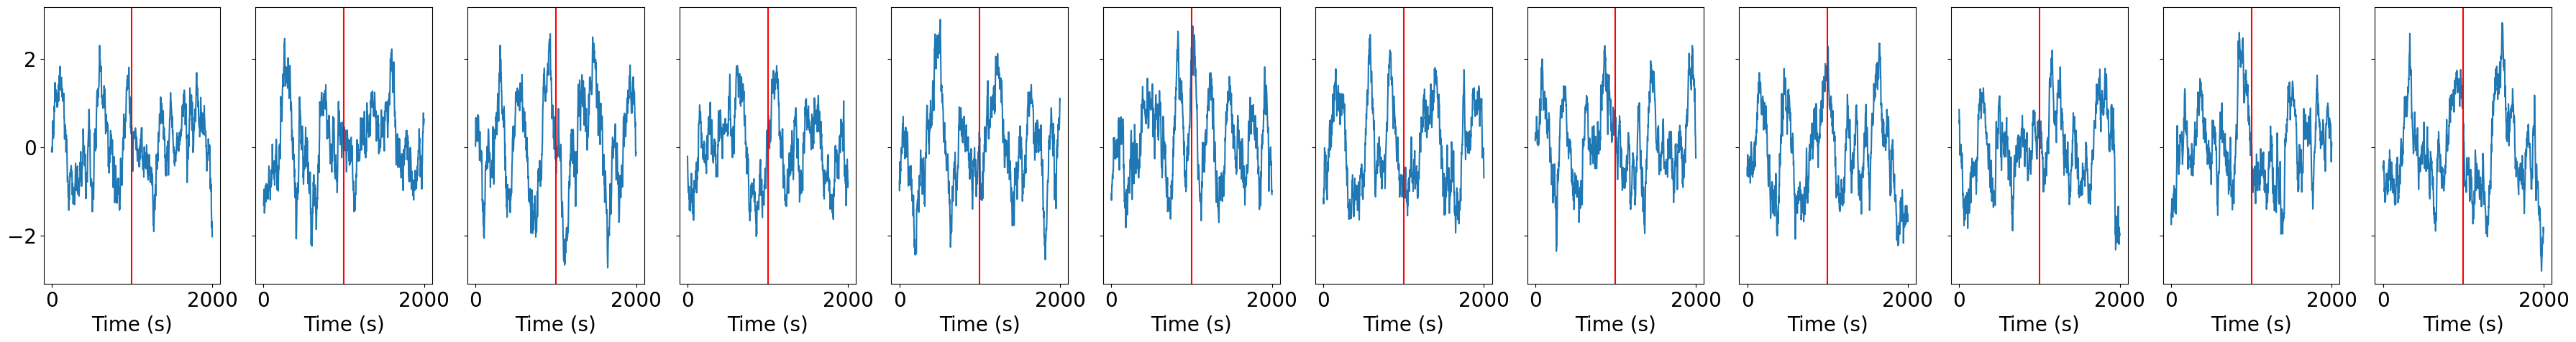

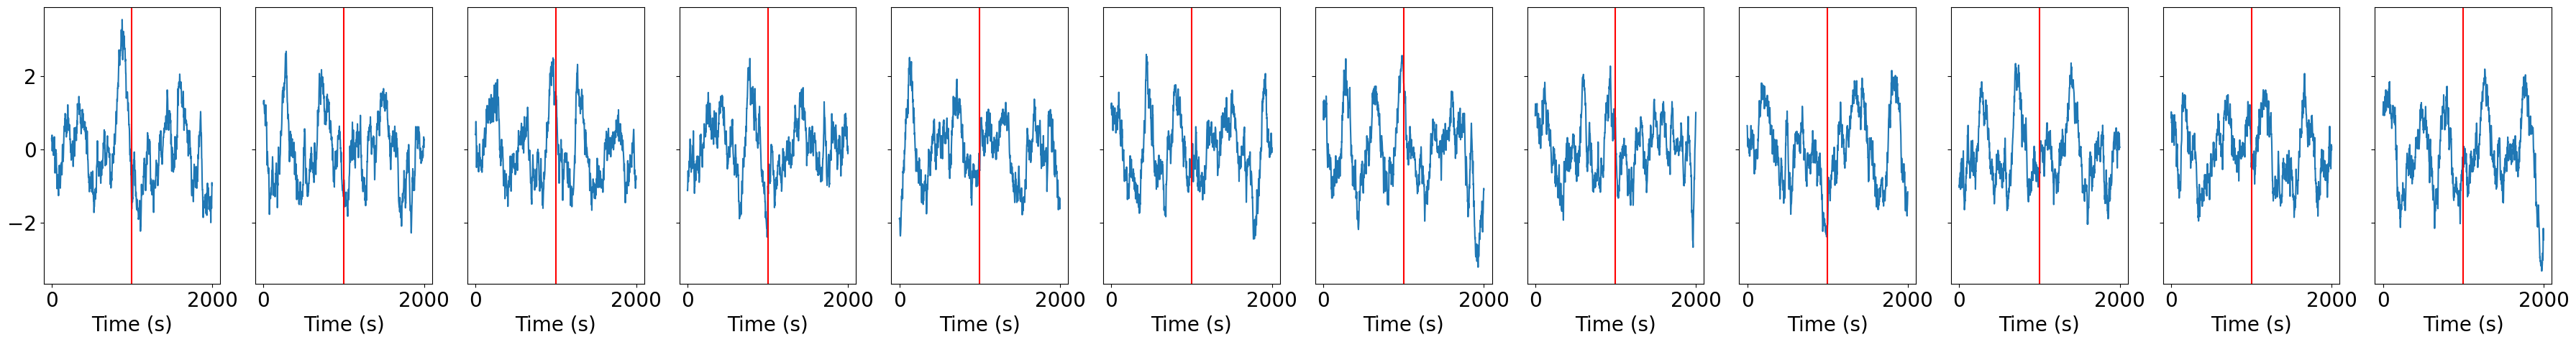

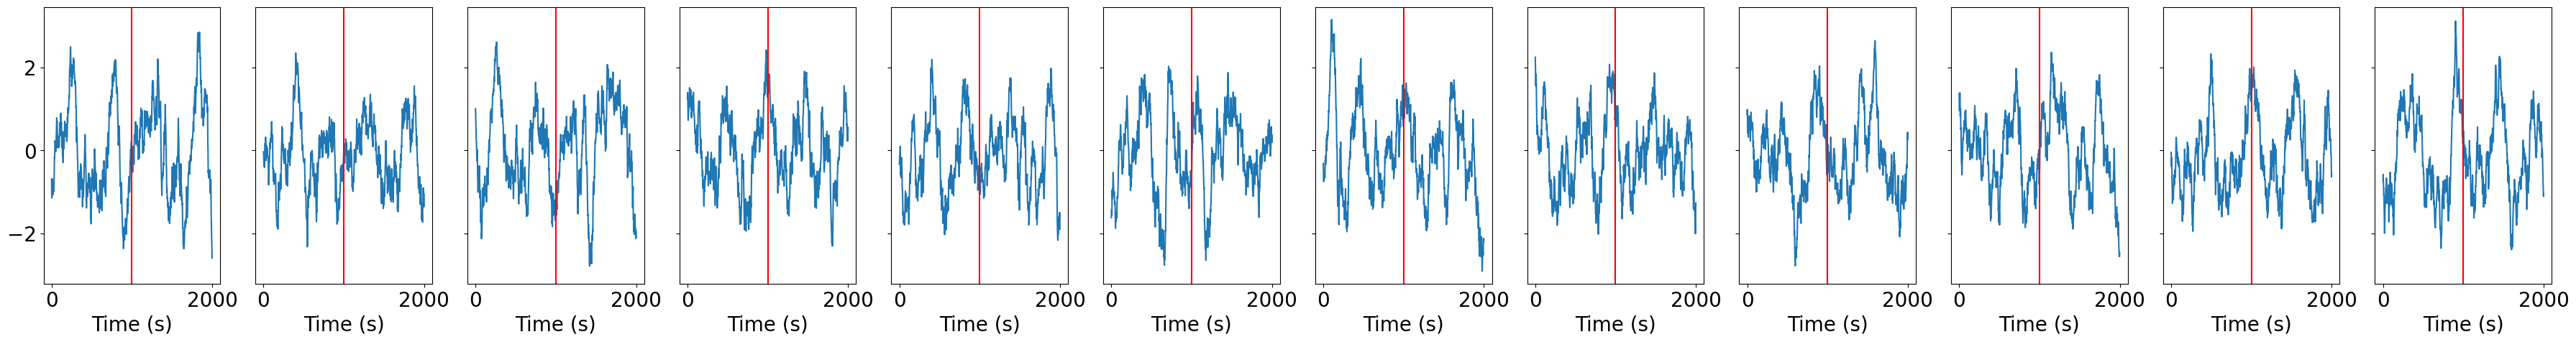

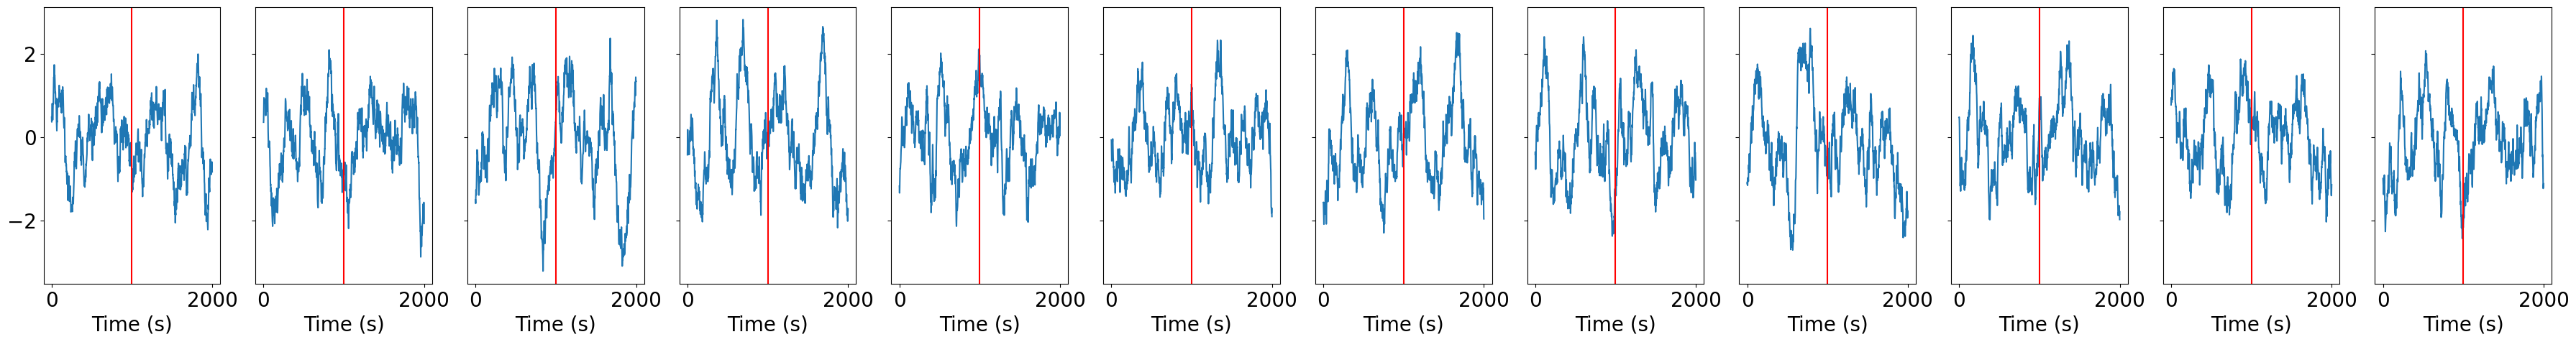

In [97]:
fig,ax = plt.subplots(1, 12, figsize = (45,5), sharey = True)
i=-1
for a in ax:  
    i+=1 
    Ti = Sampling_events[Rew_1st[i],0]
    Tf = Sampling_events[Rew_1st[i],4]
    Ts = Sampling_events[Rew_1st[i],1]
    Tr = Sampling_events[Rew_1st[i],3]
    a.plot(signal[Tr-1000:Tr+1000])
    a.axvline(1000,c='r')
    a.set_xlabel('Time (s)')

fig,ax = plt.subplots(1, 12, figsize = (45,5), sharey = True)
i=-1
for a in ax:  
    i+=1 
    Ti = Sampling_events[No_Rew_1st[i],0]
    Tf = Sampling_events[No_Rew_1st[i],4]
    Ts = Sampling_events[No_Rew_1st[i],1]
    Tr = Sampling_events[No_Rew_1st[i],3]
    a.plot(signal[Tr-1000:Tr+1000])
    a.axvline(1000,c='r')
    a.set_xlabel('Time (s)')


fig,ax = plt.subplots(1, 12, figsize = (45,5), sharey = True)
i=-1
for a in ax:  
    i+=1 
    Ti = Sampling_events[No_Rew_2nd[i],0]
    Tf = Sampling_events[No_Rew_2nd[i],4]
    Ts = Sampling_events[No_Rew_2nd[i],1]
    Tr = Sampling_events[No_Rew_2nd[i],3]
    a.plot(signal[Tr-1000:Tr+1000])
    a.axvline(1000,c='r')
    a.set_xlabel('Time (s)')

fig,ax = plt.subplots(1, 12, figsize = (45,5), sharey = True)
i=-1
for a in ax:  
    i+=1 
    Ti = Sampling_events[Rew_2nd[i],0]
    Tf = Sampling_events[Rew_2nd[i],4]
    Ts = Sampling_events[Rew_2nd[i],1]
    Tr = Sampling_events[Rew_2nd[i],3]
    a.plot(signal[Tr-1000:Tr+1000])
    a.axvline(1000,c='r')
    a.set_xlabel('Time (s)')


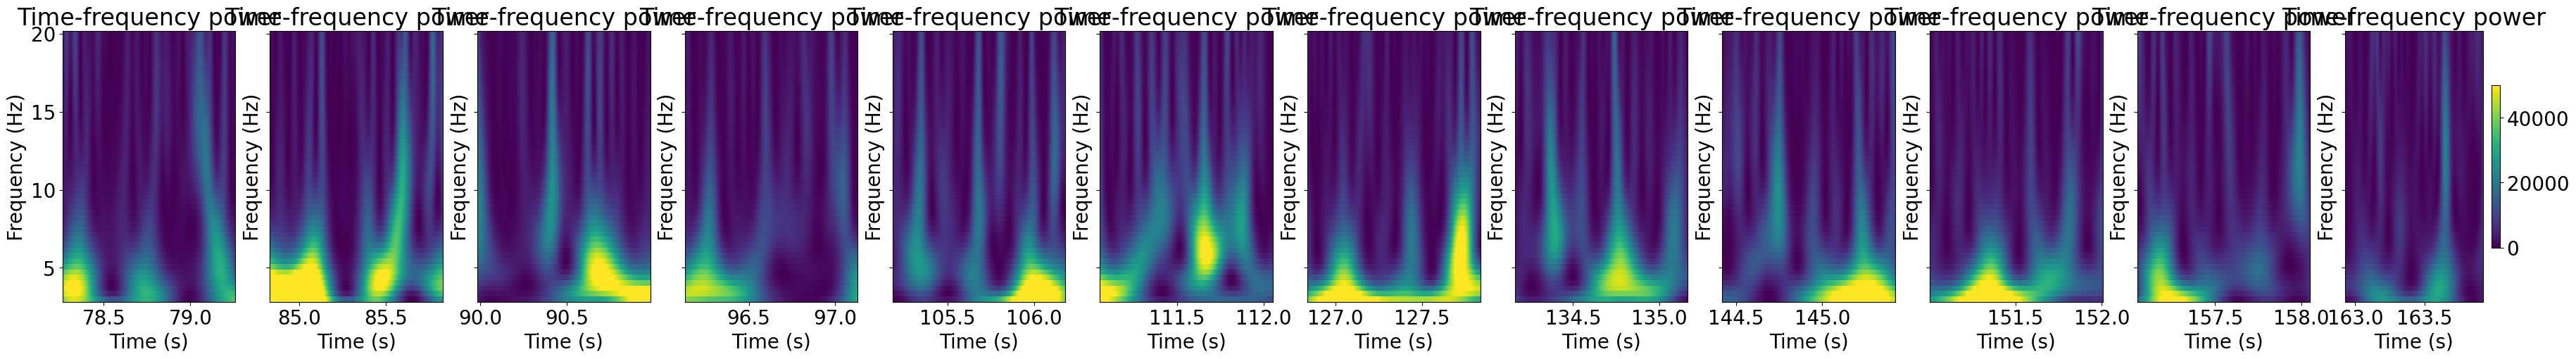

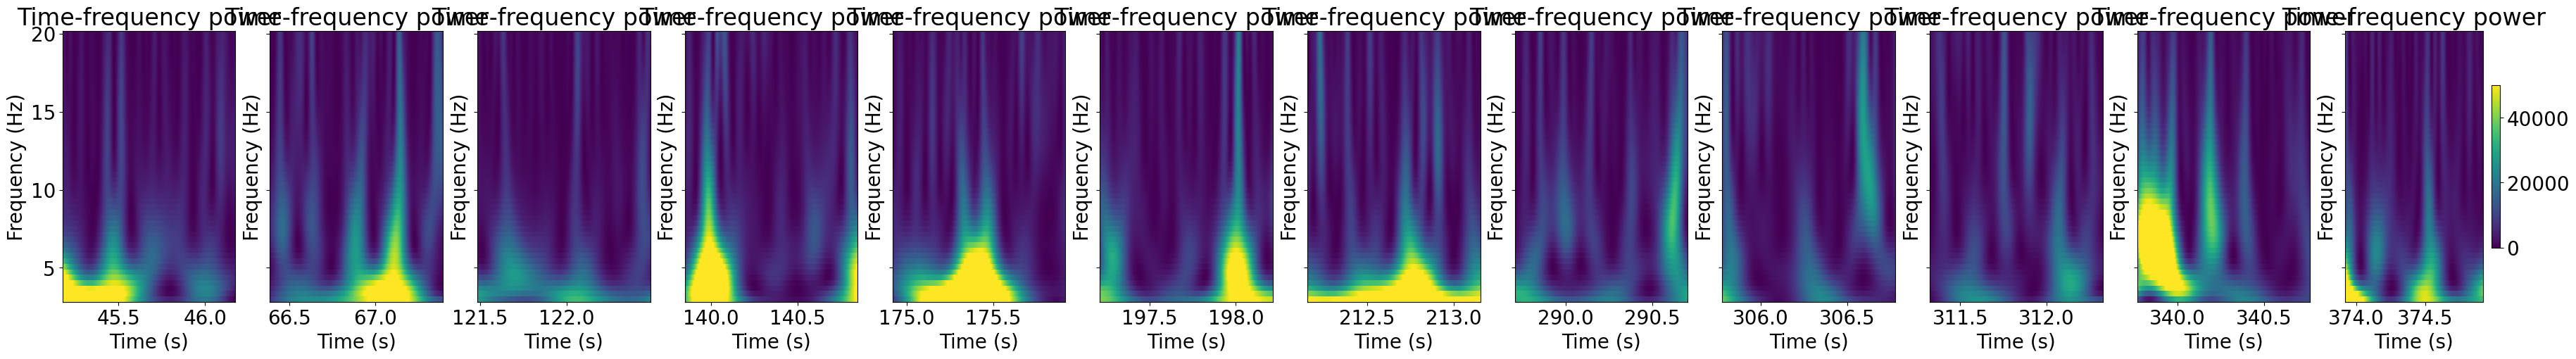

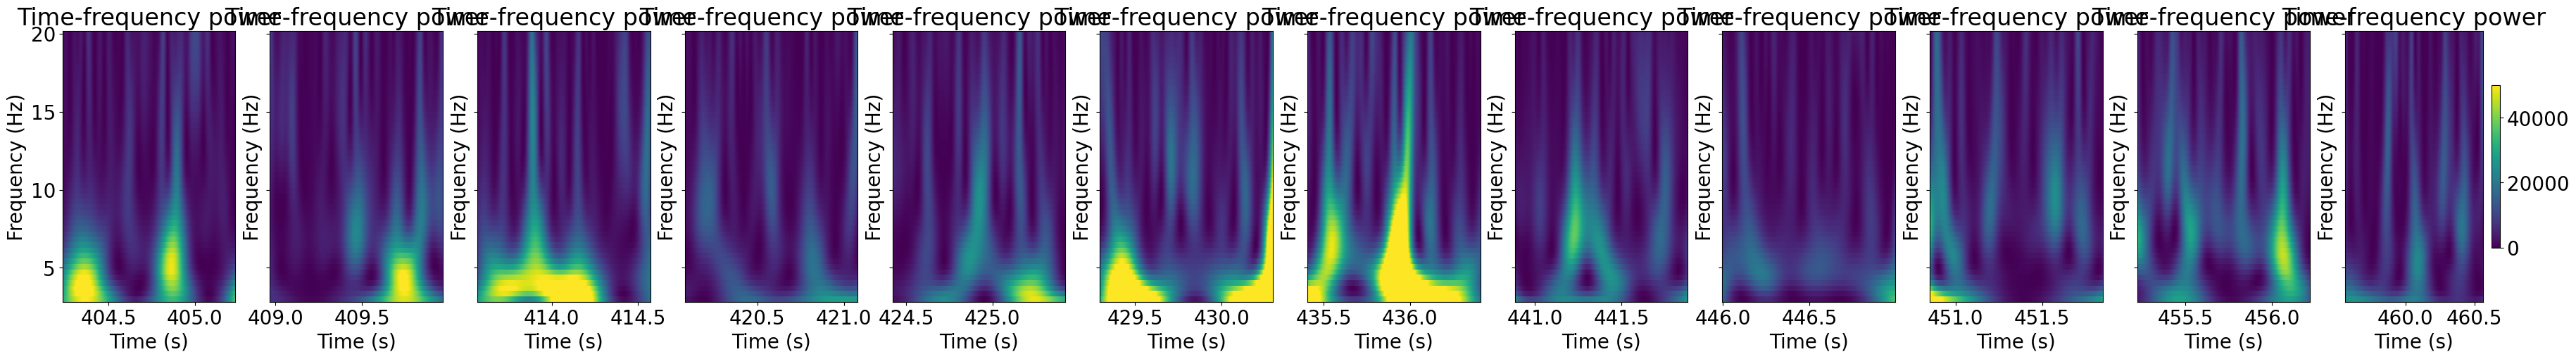

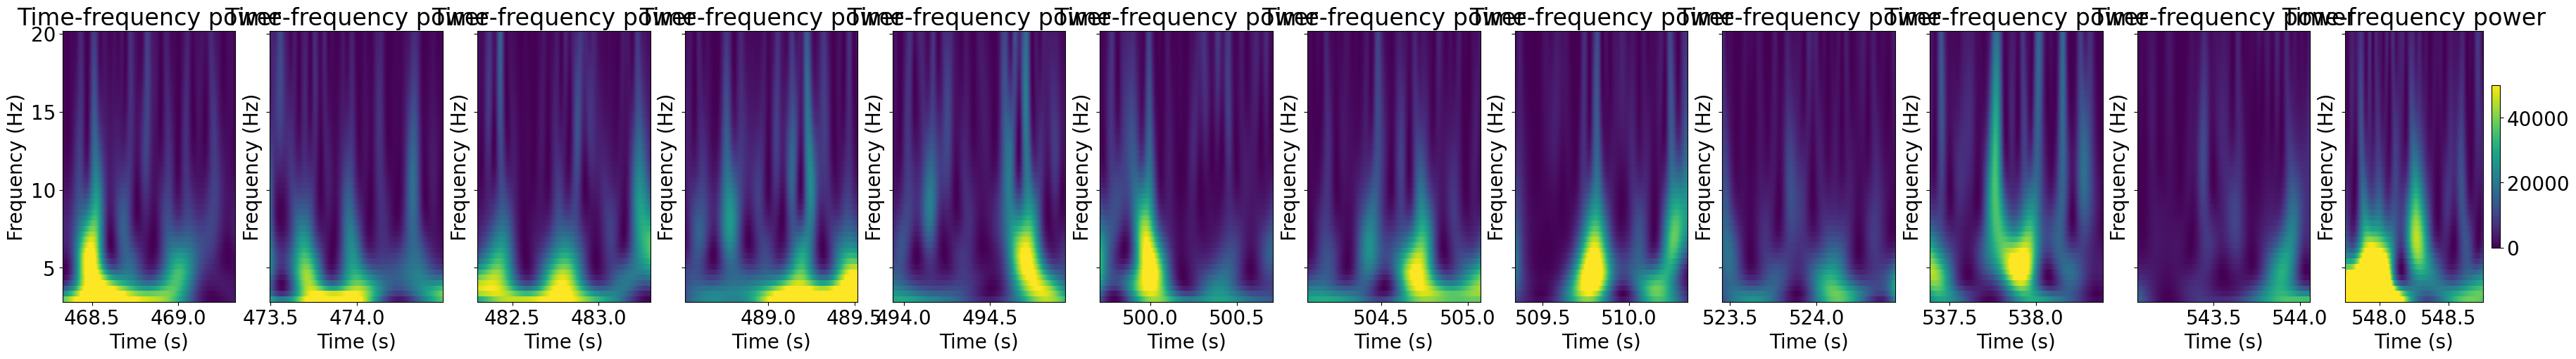

In [93]:
fig,ax = plt.subplots(1, 12, figsize = (45,5), sharey = True)
i=-1
for a in ax:
    i+=1
    Ti = Sampling_events[Rew_1st[i],0]
    Tf = Sampling_events[Rew_1st[i],4]
    Ts = Sampling_events[Rew_1st[i],1]
    Tr = Sampling_events[Rew_1st[i],3]
    pcm = a.pcolormesh(timevec[Ti:Ts],frex,tf[:,Ti:Ts],vmin=0,vmax=5e4)
    a.set_xlabel('Time (s)'), a.set_ylabel('Frequency (Hz)')
    a.set_title('Time-frequency power')
fig.colorbar(pcm, shrink=0.6)

fig,ax = plt.subplots(1, 12, figsize = (45,5), sharey = True)
i=-1
for a in ax:
    i+=1
    Ti = Sampling_events[No_Rew_1st[i],0]
    Tf = Sampling_events[No_Rew_1st[i],4]
    Ts = Sampling_events[No_Rew_1st[i],1]
    Tr = Sampling_events[No_Rew_1st[i],3]
    pcm = a.pcolormesh(timevec[Ti:Ts],frex,tf[:,Ti:Ts],vmin=0,vmax=5e4)
    a.set_xlabel('Time (s)'), a.set_ylabel('Frequency (Hz)')
    a.set_title('Time-frequency power')
fig.colorbar(pcm, shrink=0.6)

fig,ax = plt.subplots(1, 12, figsize = (45,5), sharey = True)
i=-1
for a in ax:
    i+=1
    Ti = Sampling_events[No_Rew_2nd[i],0]
    Tf = Sampling_events[No_Rew_2nd[i],4]
    Ts = Sampling_events[No_Rew_2nd[i],1]
    Tr = Sampling_events[No_Rew_2nd[i],3]
    pcm = a.pcolormesh(timevec[Ti:Ts],frex,tf[:,Ti:Ts],vmin=0,vmax=5e4)
    a.set_xlabel('Time (s)'), a.set_ylabel('Frequency (Hz)')
    a.set_title('Time-frequency power')
fig.colorbar(pcm, shrink=0.6)

fig,ax = plt.subplots(1, 12, figsize = (45,5), sharey = True)
i=-1
for a in ax:
    i+=1
    Ti = Sampling_events[Rew_2nd[i],0]
    Tf = Sampling_events[Rew_2nd[i],4]
    Ts = Sampling_events[Rew_2nd[i],1]
    Tr = Sampling_events[Rew_2nd[i],3]
    pcm = a.pcolormesh(timevec[Ti:Ts],frex,tf[:,Ti:Ts],vmin=0,vmax=5e4)
    a.set_xlabel('Time (s)'), a.set_ylabel('Frequency (Hz)')
    a.set_title('Time-frequency power')
fig.colorbar(pcm, shrink=0.6)

In [90]:
nfrex = 50 # 50 frequencies
frex  = np.linspace(3,20,nfrex) # 50 frequencies that are generated linearly between 8 and 70 Hz
fwhm  = 1/frex # full-width at half-maximum in seconds
Ti = Sampling_events[Rew_1st[0],0]
Tf = Sampling_events[Rew_1st[0],4]
Ts = Sampling_events[Rew_1st[0],1]
Tr = Sampling_events[Rew_1st[0],3]
LFP = signal[Ti:Ts]

# time vector for wavelets
wavetime = np.arange(-2,2,1/srate)
N = LFP.shape[0]
timevec = np.arange(0,N)/srate

# initialize matrices for wavelets
wavelets = np.zeros( (nfrex,len(wavetime)) ,dtype=complex)

# create complex Morlet wavelet family
for wi in range(0,nfrex):    
    gaussian = np.exp( -(4*np.log(2)*wavetime**2) / fwhm[wi]**2 )   # Gaussian  
    wavelets[wi,:] = np.exp(1j*2*np.pi*frex[wi]*wavetime) * gaussian # complex Morlet wavelet

# 1 Run convolution using spectral multiplication

#use the fileter data as data
data = LFP # low passes and notched data 

# convolution parameters
nconv = len(timevec) + len(wavetime) - 1 # M+N-1
halfk = int( np.floor(len(wavetime)/2) )

# Fourier spectrum of the signal
dataX = scipy.fftpack.fft(data,nconv) # here we can the fft of the data only once

# initialize time-frequency matrix. The whole trial
tf = np.zeros( (nfrex,len(timevec)) )

# convolution per frequency. We alternatively use the python conv function
for fi in range(0,nfrex):      
    waveX = scipy.fftpack.fft(wavelets[fi,:],nconv)# FFT of the wavelet    
    waveX = waveX / np.abs(np.max(waveX)) # amplitude-normalize the wavelet in the frequency domain    
    convres = scipy.fftpack.ifft( waveX*dataX ) # convolution # inverse of the ifft    
    convres = convres[halfk-1:-halfk]  # trim the "wings"  # result is also complex    
    tf[fi,:] = np.abs(convres)**2 # # extract power from complex signal, we get the magnitude(np.abs)

plt.figure()
i+=1
Ti = Sampling_events[Rew_2nd[i],0]
Tf = Sampling_events[Rew_2nd[i],4]
Ts = Sampling_events[Rew_2nd[i],1]
Tr = Sampling_events[Rew_2nd[i],3]
pcm = a.pcolormesh(timevec[Ti:Ts],frex,tf[:,Ti:Ts],vmin=0,vmax=5e4)
a.set_xlabel('Time (s)'), a.set_ylabel('Frequency (Hz)')
a.set_title('Time-frequency power')
fig.colorbar(pcm, shrink=0.6)

-0.006406825498945697